**Part 1**

In [ ]:
!pip install torch torchvision matplotlib albumentations opencv-python -q

In [ ]:
import torch
import torchvision.models as models
from torchvision.models import MobileNet_V3_Large_Weights
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import requests
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
part1_dir = "/content/drive/MyDrive/Image_Processing_PROJ3/Part1/"
images_dir = os.path.join(part1_dir, "Images")
results_dir = os.path.join(part1_dir, "Results")

# Create directories
os.makedirs(images_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print(f"Directories ready:\n {images_dir}\n {results_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories ready:
 /content/drive/MyDrive/Image_Processing_PROJ3/Part1/Images
 /content/drive/MyDrive/Image_Processing_PROJ3/Part1/Results


In [ ]:
print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu124
GPU available: True
GPU: NVIDIA L4


In [ ]:
def select_backbone_architecture(member_id1, member_id2):
    # Concatenate both member IDs into a single string
    combined_ids = str(member_id1) + str(member_id2)

    # Sum all digits from the combined string
    digit_sum = sum(int(d) for d in combined_ids)

    # Sum the digits of the previous sum (to get a single digit)
    final_sum = sum(int(d) for d in str(digit_sum))

    # Select backbone architecture based on the final_sum rules
    if 0 <= final_sum <= 3:
        return "ResNet18"
    elif 4 <= final_sum <= 6:
        return "VGG16"
    else:
        return "MobileNetV3"

# Group member IDs (provided as strings)
member_id1 = "322216128"
member_id2 = "322543448"

# Select backbone according to the defined process
selected_backbone = select_backbone_architecture(member_id1, member_id2)

# Print selected backbone (MobileNetV3 in this case)
print(f"Selected Backbone: {selected_backbone}")

Selected Backbone: MobileNetV3


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
image_files = [
    "640px-Parthenos_sylvia_philippensis.jpg",
    "Air-to-air_photo_of_a_Sukhoi_Superjet_100_(RA-97004)_over_Italy.jpg",
    "Alaska_Red_Fox.jpg",
    "Norton_Motorcycle.jpg",
    "Red_Apple.jpg",
    "Sofa.jpg"
]

image_list = []
for file in image_files:
    path = os.path.join(images_dir, file)
    try:
        image = Image.open(path)
        image = transform(image)
        image_list.append(image)
    except Exception as e:
        print(f"Failed to load {file}: {e}")

print(f"Loaded {len(image_list)} images.")

Loaded 6 images.


In [ ]:
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
model.eval()

# Load ImageNet labels
imagenet_labels = requests.get(
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
).text.splitlines()

print("ImageNet labels loaded.")

ImageNet labels loaded.


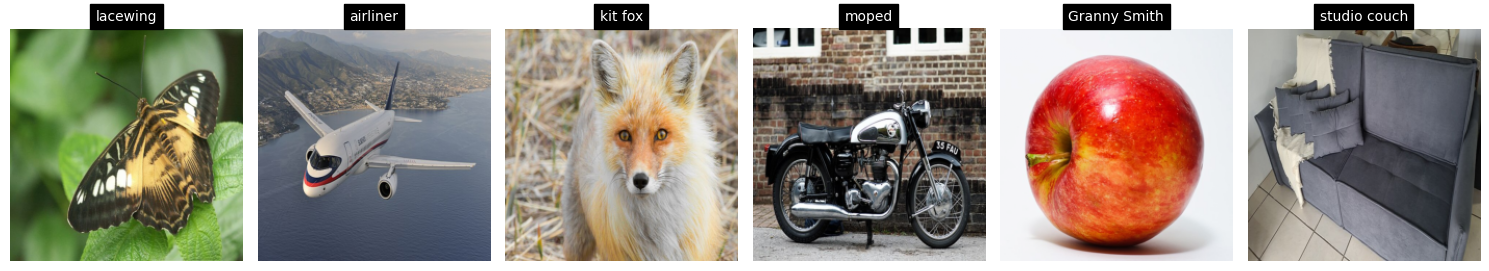

Inference results saved at /content/drive/MyDrive/Image_Processing_PROJ3/Part1/Results/inference_results.png


In [ ]:
fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
model_predictions = []

for idx, image in enumerate(image_list):
    input_tensor = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)

    _, pred_idx = outputs.max(1)
    label = imagenet_labels[pred_idx.item()]
    model_predictions.append(label)

    # Unnormalize for visualization
    img_vis = image.clone()
    img_vis = img_vis * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis += torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img_vis = img_vis.clamp(0, 1)

    axes[idx].imshow(img_vis.permute(1, 2, 0))
    axes[idx].axis("off")
    axes[idx].set_title(label, fontsize=10, backgroundcolor="black", color="white", pad=6)

plt.tight_layout()

# Save plot
pred_img_path = os.path.join(results_dir, "inference_results.png")
plt.savefig(pred_img_path)
plt.show()

print(f"Inference results saved at {pred_img_path}")

In [ ]:
df = pd.DataFrame({
    "Image": ["Butterfly", "Airplane", "Fox", "Motorcycle", "Apple", "Sofa"],
    "Prediction": model_predictions
})

csv_path = os.path.join(results_dir, "classification_results.csv")
df.to_csv(csv_path, index=False)

print(f"Results saved at {csv_path}")
df

Results saved at /content/drive/MyDrive/Image_Processing_PROJ3/Part1/Results/classification_results.csv


,Image,Prediction
0,Butterfly,lacewing
1,Airplane,airliner
2,Fox,kit fox
3,Motorcycle,moped
4,Apple,Granny Smith
5,Sofa,studio couch


**Part 2**

In [ ]:
!pip install torch torchvision albumentations matplotlib tensorboard opencv-python pycocotools kaggle -q

In [ ]:
!pip install kaggle  # Install Kaggle API if not already installed

# Create a Kaggle directory
!mkdir -p /content/.kaggle

# Move it to the correct directory
!mv kaggle.json /content/.kaggle/

# Set correct permissions
!chmod 600 /content/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# Download dataset (force re-download if needed)
!kaggle datasets download -d sharansmenon/aquarium-dataset --force

# Unzip and overwrite files if they exist
!unzip -o aquarium-dataset.zip -d aquarium_dataset

Dataset URL: https://www.kaggle.com/datasets/sharansmenon/aquarium-dataset
License(s): copyright-authors
 99% 67.0M/68.0M [00:04<00:00, 23.6MB/s]
100% 68.0M/68.0M [00:04<00:00, 16.8MB/s]
Archive:  aquarium-dataset.zip
  inflating: aquarium_dataset/Aquarium Combined/README.dataset.txt  
  inflating: aquarium_dataset/Aquarium Combined/README.roboflow.txt  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg  
  inflating: aquarium_dataset/Aquarium Combined/test/IMG_2371_jpeg_jpg.rf.5450

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_large
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os

In [ ]:
class MobileNetV3Detector(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = mobilenet_v3_large(pretrained=True)
        self.features = backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(960, 128),  # Backbone output channels = 960
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        bbox = self.regressor(x)
        return bbox

In [ ]:
def iou_loss(preds, targets):
    # Convert center/width/height to corner coordinates
    preds_x1 = preds[:, 0] - preds[:, 2] / 2
    preds_y1 = preds[:, 1] - preds[:, 3] / 2
    preds_x2 = preds[:, 0] + preds[:, 2] / 2
    preds_y2 = preds[:, 1] + preds[:, 3] / 2

    targets_x1 = targets[:, 0] - targets[:, 2] / 2
    targets_y1 = targets[:, 1] - targets[:, 3] / 2
    targets_x2 = targets[:, 0] + targets[:, 2] / 2
    targets_y2 = targets[:, 1] + targets[:, 3] / 2

    # Intersection area
    xi1 = torch.max(preds_x1, targets_x1)
    yi1 = torch.max(preds_y1, targets_y1)
    xi2 = torch.min(preds_x2, targets_x2)
    yi2 = torch.min(preds_y2, targets_y2)

    inter_area = (xi2 - xi1).clamp(min=0) * (yi2 - yi1).clamp(min=0)
    preds_area = (preds_x2 - preds_x1) * (preds_y2 - preds_y1)
    targets_area = (targets_x2 - targets_x1) * (targets_y2 - targets_y1)

    union_area = preds_area + targets_area - inter_area
    iou = inter_area / (union_area + 1e-6)

    return 1 - iou.mean()

In [ ]:
def custom_collate_fn(batch):
    images, targets = [], []

    for image, boxes in batch:
        if boxes.size(0) == 0:
            continue  # Skip images with no boxes
        images.append(image)
        targets.append(boxes)

    if len(images) == 0:
        return torch.empty(0), torch.empty(0)

    images = torch.stack(images)
    return images, targets

In [ ]:
!pip install pycocotools

In [ ]:
class StingrayCOCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        for ann in anns:
            x, y, width, height = ann['bbox']
            x_center = (x + width / 2) / img_info['width']
            y_center = (y + height / 2) / img_info['height']
            width /= img_info['width']
            height /= img_info['height']
            boxes.append([x_center, y_center, width, height])

        labels = ['stingray'] * len(boxes)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']

        boxes = torch.tensor(boxes, dtype=torch.float32)
        return image, boxes

In [ ]:
# Define augmentations
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

# Create dataset
train_dataset = StingrayCOCODataset(
    annotation_file='/content/aquarium_dataset/Aquarium Combined/train/_annotations.coco.json',
    image_dir='/content/aquarium_dataset/Aquarium Combined/train',
    transforms=train_transforms
)

# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    collate_fn=custom_collate_fn
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
model = MobileNetV3Detector().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, boxes in train_loader:
        if images.numel() == 0:
            continue

        images = images.cuda()
        optimizer.zero_grad()

        batch_loss = 0
        valid_imgs = 0

        for img, box in zip(images, boxes):
            if box.numel() == 0:
                continue

            img = img.unsqueeze(0).cuda()
            box = box.cuda().unsqueeze(0) if box.dim() == 1 else box.cuda()

            pred = model(img)
            loss = iou_loss(pred, box)
            batch_loss += loss
            valid_imgs += 1

        if valid_imgs > 0:
            batch_loss /= valid_imgs
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Save model weights
torch.save(model.state_dict(), '/content/trained_stingray_model.pth')

Epoch 1/20, Loss: 0.8775
Epoch 2/20, Loss: 0.8738
Epoch 3/20, Loss: 0.8715
Epoch 4/20, Loss: 0.8706
Epoch 5/20, Loss: 0.8692
Epoch 6/20, Loss: 0.8665
Epoch 7/20, Loss: 0.8665
Epoch 8/20, Loss: 0.8641
Epoch 9/20, Loss: 0.8629
Epoch 10/20, Loss: 0.8592
Epoch 11/20, Loss: 0.8568
Epoch 12/20, Loss: 0.8565
Epoch 13/20, Loss: 0.8562
Epoch 14/20, Loss: 0.8533
Epoch 15/20, Loss: 0.8531
Epoch 16/20, Loss: 0.8477
Epoch 17/20, Loss: 0.8459
Epoch 18/20, Loss: 0.8453
Epoch 19/20, Loss: 0.8413
Epoch 20/20, Loss: 0.8394


In [ ]:
import cv2
import torch

cap = cv2.VideoCapture('/content/stingray_video.mp4')
model.eval()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_stingray.mp4', fourcc, 20.0,
                      (int(cap.get(3)), int(cap.get(4))))

# Initialize smoothing parameters outside loop
alpha = 0.1  # You can adjust (0.1-0.5 is typical)
smoothed_bbox = None

with torch.no_grad():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image, (224, 224))

        transformed = train_transforms(image=resized, bboxes=[], labels=[])
        tensor_img = transformed['image'].unsqueeze(0).cuda()

        pred_bbox = model(tensor_img)[0].cpu().numpy()

        h, w, _ = frame.shape
        bbox_current = pred_bbox  # Renamed for clarity

        if smoothed_bbox is None:
            smoothed_bbox = bbox_current
        else:
            smoothed_bbox = alpha * bbox_current + (1 - alpha) * smoothed_bbox

        x_center, y_center, bbox_width, bbox_height = smoothed_bbox

        x1 = int((x_center - bbox_width / 2) * w)
        y1 = int((y_center - bbox_height / 2) * h)
        x2 = int((x_center + bbox_width / 2) * w)
        y2 = int((y_center + bbox_height / 2) * h)

        # Filter unrealistic bounding boxes
        if bbox_width <= 0.1 or bbox_height <= 0.1 or bbox_width >= 0.8 or bbox_height >= 0.8:
            continue

        if y_center < 0.2:
            continue

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

Part 3

In [ ]:

!pip install torch torchvision albumentations matplotlib tensorboard opencv-python


In [ ]:
class MultiBoxCOCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            x, y, width, height = ann['bbox']
            x_center = (x + width / 2) / img_info['width']
            y_center = (y + height / 2) / img_info['height']
            width /= img_info['width']
            height /= img_info['height']
            boxes.append([x_center, y_center, width, height])

        labels = ['stingray'] * len(boxes)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']

        boxes = torch.tensor(boxes, dtype=torch.float32)

        return image, boxes


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.CoarseDropout(max_holes=6, max_height=40, max_width=40, fill_value=0, p=0.5),  # Replaces Cutout
    ToTensorV2(),
])


In [ ]:
def custom_collate_fn(batch):
    images, targets = [], []
    for img, boxes in batch:
        if boxes.numel() == 0:
            continue  # skip empty boxes
        images.append(img)
        targets.append(boxes)
    images = torch.stack(images)
    return images, targets


In [ ]:
def multi_iou_loss(preds, targets):
    loss = 0
    batch_size = preds.size(0)

    for i in range(batch_size):
        pred_boxes = preds[i, :, :4]
        pred_scores = preds[i, :, 4]

        gt_boxes = targets[i].cuda()

        if gt_boxes.numel() == 0:
            continue

        loss_per_gt = []
        for gt_box in gt_boxes:
            ious = []
            for pred_box in pred_boxes:
                iou = calculate_iou(pred_box, gt_box)
                ious.append(iou)
            max_iou = max(ious)
            loss_per_gt.append(1 - max(ious))

        loss_per_image = torch.stack(loss_per_gt).mean()
        loss_per_gt = torch.tensor(loss_per_image).mean()
        loss += loss_per_image
    return loss / len(gt_boxes)

# Helper IOU function:
def calculate_iou(box1, box2):
    # Box 1 coordinates
    box1_x1 = box1[0] - box1[2] / 2
    box1_y1 = box1[1] - box1[3] / 2
    box1_x2 = box1[0] + box1[2] / 2
    box1_y2 = box1[1] + box1[3] / 2

    # Box 2 coordinates
    box2_x1 = box2[0] - box2[2] / 2
    box2_y1 = box2[1] - box2[3] / 2
    box2_x2 = box2[0] + box2[2] / 2
    box2_y2 = box2[1] + box2[3] / 2

    # Intersection coordinates
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)



In [ ]:

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_large
import torchvision.ops as ops
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MobileNetV3MultiBoxDetector(nn.Module):
    def __init__(self, num_boxes=12):
        super().__init__()
        self.num_boxes = num_boxes
        backbone = mobilenet_v3_large(weights='DEFAULT')
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.Linear(512, num_boxes * 5),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        out = self.regressor(x)
        out = out.view(-1, self.num_boxes, 5)

        # Explicit sigmoid activation for coordinates and objectness separately:
        coords = torch.sigmoid(out[..., :4])  # coordinates normalized
        scores = torch.sigmoid(out[..., 4])     # explicit objectness score
        return torch.cat([coords, scores.unsqueeze(-1)], dim=-1)


model = MobileNetV3MultiBoxDetector(num_boxes=5).to(device)
model.load_state_dict(torch.load('stingray_detector_weights.pth'))
model.eval()


In [ ]:
import torch
import torchvision.ops as ops
from torchvision.ops import generalized_box_iou_loss, box_convert

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MobileNetV3MultiBoxDetector(num_boxes=5).to(device)

# Optimizer & Training Settings
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, gt_boxes_list in train_loader:
        # Move images and ground truth boxes to GPU if available
        images = images.to(device)
        optimizer.zero_grad()

        batch_loss = 0
        valid_samples = 0

        for img, gt_boxes in zip(images, gt_boxes_list):
            img = img.unsqueeze(0).to(device)  # Ensure image is on GPU
            preds = model(img).squeeze(0)  # [num_pred_boxes, 5]

            pred_boxes = preds[:, :4]
            scores = preds[:, 4]

            # Confidence Filtering
            valid_mask = scores > 0.1  # Lowered for multiple detections
            pred_boxes_filtered = pred_boxes[valid_mask]
            scores_filtered = scores[valid_mask]

            if pred_boxes_filtered.size(0) == 0 or gt_boxes.size(0) == 0:
                continue

            gt_boxes = gt_boxes.to(device)

            # Convert to XYXY format for IoU calculations
            pred_boxes_xyxy = ops.box_convert(pred_boxes_filtered, 'cxcywh', 'xyxy')
            gt_boxes_xyxy = box_convert(gt_boxes, 'cxcywh', 'xyxy')

            # Compute IoU Matrix
            ious = ops.box_iou(pred_boxes_xyxy, gt_boxes_xyxy)

            # Find best match
            matched_pred_indices = torch.argmax(ious, dim=0)
            matched_preds = pred_boxes_xyxy[matched_pred_indices]

            # Compute loss
            loss = generalized_box_iou_loss(matched_preds, gt_boxes_xyxy).mean()

            batch_loss += loss
            valid_samples += 1

        if valid_samples > 0:
            batch_loss = batch_loss / valid_samples
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


In [ ]:
torch.save(model.state_dict(), 'stingray_detector_weights.pth')


In [ ]:
model = MobileNetV3MultiBoxDetector(num_boxes=2).to(device)

In [ ]:
import torchvision.transforms as T
import torchvision.ops as ops
import torch
import cv2
import numpy as np

def soft_nms(boxes, scores, sigma=0.5, iou_threshold=0.5, top_k=200):
    """
    Soft-NMS implementation with Gaussian decay.
    """
    boxes = boxes.clone()
    scores = scores.clone()

    keep = []
    while boxes.shape[0] > 0:
        max_idx = torch.argmax(scores)
        keep.append(max_idx.item())

        if boxes.shape[0] == 1 or len(keep) >= top_k:
            break

        ious = ops.box_iou(boxes[max_idx].unsqueeze(0), boxes)[0]
        decay = torch.exp(-(ious ** 2) / sigma)
        scores *= decay

        boxes = torch.cat((boxes[:max_idx], boxes[max_idx+1:]), dim=0)
        scores = torch.cat((scores[:max_idx], scores[max_idx+1:]), dim=0)

    return torch.tensor(keep, dtype=torch.long)

def inference_with_soft_nms(frame, model, iou_threshold=0.3, conf_threshold=0.03, sigma=0.5, top_k=200, device="cuda"):
    """
    Perform inference on a single frame with Soft-NMS applied.
    """
    orig_h, orig_w, _ = frame.shape
    resized = cv2.resize(frame, (224, 224))

    transform = T.Compose([T.ToTensor()])
    tensor_img = transform(resized).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(tensor_img)[0]

    boxes = predictions[:, :4].to("cpu")
    scores = predictions[:, 4].to("cpu")

    valid_mask = scores > conf_threshold
    boxes = boxes[valid_mask]
    scores = scores[valid_mask]

    if boxes.shape[0] == 0:
        return frame

    boxes_px = []
    for box in boxes:
        x_center, y_center, width, height = box.numpy()
        x1 = float((x_center - width / 2) * orig_w)
        y1 = float((y_center - height / 2) * orig_h)
        x2 = float((x_center + width / 2) * orig_w)
        y2 = float((y_center + height / 2) * orig_h)
        boxes_px.append([x1, y1, x2, y2])

    boxes_px = torch.tensor(boxes_px, dtype=torch.float32)

    keep = soft_nms(boxes_px, scores, sigma=sigma, iou_threshold=iou_threshold, top_k=top_k)

    for idx in keep:
        x1, y1, x2, y2 = map(int, boxes_px[idx].numpy())
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return frame


In [ ]:
import torch
import cv2

input_video = '/content/stingray_video.mp4'
output_video = 'stingray_detection_output.mp4'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

cap = cv2.VideoCapture(input_video)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = inference_with_soft_nms(frame, model, iou_threshold=0.3, conf_threshold=0.4, device=device)
    out.write(frame)

cap.release()
out.release()
print(f"Output video saved to {output_video}")
